<a href="https://colab.research.google.com/github/ronniemi/deep_learning/blob/master/assignment1_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import random
from os import listdir
from os.path import join
import pickle

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
import seaborn as sns

from skimage.transform import resize

from keras.models import Model, Sequential, model_from_json
from keras.layers import Dense, Conv2D, Flatten, Input, AvgPool2D, MaxPool2D, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import regularizers
from keras.callbacks import LearningRateScheduler

from keras.datasets import cifar10

Using TensorFlow backend.


In [0]:
# read the data

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
# normalise and center the mean

x_train = x_train.astype("float32")  
x_test = x_test.astype("float32")
mean = np.mean(x_train)
std = np.std(x_train)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

In [0]:
#data augmentation

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [6]:
# build the model

weight_decay = 1e-4

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
__________

In [0]:
# define lerning rate that will be use as callback

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 50:
        lrate = 0.0005
    elif epoch > 75:
        lrate = 0.0003       
    return lrate

In [8]:
# fit the model

batch_size = 128
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0] / batch_size, epochs=100, verbose=1, validation_data=(x_test,y_test), callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/100
391/390 [==============================] - 35s 91ms/step - loss: 1.8337 - acc: 0.3965 - val_loss: 1.5648 - val_acc: 0.4882
Epoch 2/100
391/390 [==============================] - 33s 84ms/step - loss: 1.3647 - acc: 0.5265 - val_loss: 1.1860 - val_acc: 0.5951
Epoch 3/100
391/390 [==============================] - 33s 85ms/step - loss: 1.1835 - acc: 0.5901 - val_loss: 1.0420 - val_acc: 0.6410
Epoch 4/100
391/390 [==============================] - 33s 84ms/step - loss: 1.0805 - acc: 0.6254 - val_loss: 0.9910 - val_acc: 0.6659
Epoch 5/100
391/390 [==============================] - 33s 84ms/step - loss: 1.0041 - acc: 0.6542 - val_loss: 0.9063 - val_acc: 0.6935
Epoch 6/100
391/390 [==============================] - 33s 83ms/step - loss: 0.9488 - acc: 0.6739 - val_loss: 0.9729 - val_acc: 0.6817
Epoch 7/100
391/390 [==============================] - 33s 83ms/step - loss: 0.9100 - acc: 0.6878 - val_loss: 1.0056 - val_acc: 0.6719
Epoch 8/100
391/390 [==============================] - 


[[845  30  25   5   6   0  17   9  36  27]
 [  3 954   0   0   2   0   3   1  11  26]
 [ 39   5 775  12  44  11  95  11   5   3]
 [ 11  20  58 562  60  60 172  23  16  18]
 [  5   0  45   5 838   5  82  17   3   0]
 [  7   9  64  92  40 652  97  30   1   8]
 [  3   1  10   4   4   1 969   2   4   2]
 [ 10   5  29   4  50  14  31 845   2  10]
 [ 46  28   6   1   1   0   7   0 894  17]
 [ 10  75   4   3   1   0   8   2  10 887]]

model accuracy on test set is: 82.21000000000001%


Text(0.5,1,'CIFAR-10 Convolutional model \n classification results on test set')

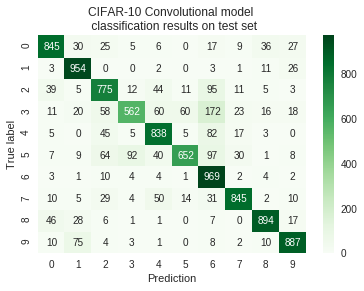

In [9]:
 # accuracy on test set

y_test_cat = np.argmax(y_test, axis=1)
preds = model.predict(x_test)
pred_cat = np.argmax(preds, axis=1)
print('')
print(confusion_matrix(y_test_cat, pred_cat))
print()
print('model accuracy on test set is: {}%'.format(accuracy_score(y_test_cat, pred_cat)*100))
sns.heatmap(confusion_matrix(y_test_cat, pred_cat), cmap='Greens', annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('CIFAR-10 Convolutional model \n classification results on test set')


[[4380  102  113   13   47    4   69   39  132  101]
 [   4 4879    6    2    0    2   11    2   19   75]
 [ 162   20 4114   36  147   26  404   39   37   15]
 [  65   42  273 3146  234  227  838   79   40   56]
 [  26    0  137   38 4346   16  348   72   11    6]
 [  22   28  245  433  234 3355  486  163   14   20]
 [  13   11   40    7   14    2 4891    2   16    4]
 [  27   25  118   51  174   34  105 4439    8   19]
 [  82   85   22    4    6    0   34    4 4689   74]
 [  29  266    4    6    5    2   39    6   33 4610]]

model accuracy on train set is: 85.698%


Text(0.5,1,'CIFAR-10 Convolutional model \n classification results on train set')

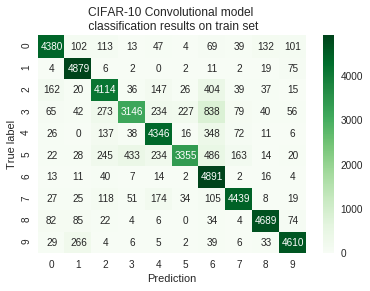

In [10]:
# accuracy on train set

y_train_cat = np.argmax(y_train, axis=1)
preds = model.predict(x_train)
pred_cat = np.argmax(preds, axis=1)
print('')
print(confusion_matrix(y_train_cat, pred_cat))
print()
print('model accuracy on train set is: {}%'.format(accuracy_score(y_train_cat, pred_cat)*100))
sns.heatmap(confusion_matrix(y_train_cat, pred_cat), cmap='Greens', annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('CIFAR-10 Convolutional model \n classification results on train set')

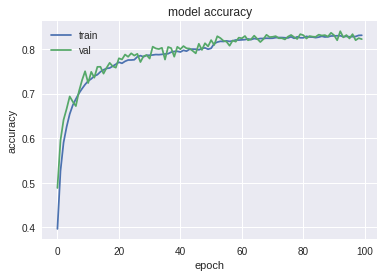

In [11]:
# plotting accuracy train-test

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

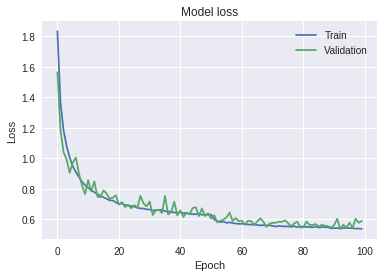

In [12]:
# plotting loss function

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()